# Training DIPS

**Goal:** Quick study of training DIPS for a few epochs to see a potential workflow the IP based NN algs.

<img src="img/dips_architecture.png" width="600">

In [1]:
import h5py
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt

from keras.layers import BatchNormalization, Layer, TimeDistributed, Dropout
from keras.layers import Dense, Input, ReLU, Masking, LSTM
from keras.models import Model
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K
from plottingFunctions import sigBkgEff

# Some magic so that the notebook will reload external python modules
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


**Step 1:** Load in the data (preprocessed in the same way as the DL1 inputs from the `Sample-preparation` notebook.)

In [2]:
# Can also change to where you saved your files from Sample-preparation notebook
file_path = "/eos/home-m/mguth/public/btagging-ml_tutorial_files"

In [3]:
trainfile_name = os.path.join(file_path, "MC16d_hybrid-training_sample-NN.h5")
h5f_train = h5py.File(trainfile_name, 'r')

'''
For a first training, just look at part of the data
'''
Ntrain = 200000
X_train = h5f_train['X_trk_train'][:200000]
y_train = h5f_train['Y_train'][:200000]

h5f_train.close()

**Step 2:** Set up the architecture

For the most part, [Keras](https://keras.io) is very modular and lets you stack the common layers that you care just like legos to build a custom architecture, and these are the layers that are loaded above.

For the Deep-Sets model, we just needed a custom layer to implement this sum over tracks. 

The only custom layer that we needed was a Sum layer, which is in the block below.

In [4]:
class Sum(Layer):
    """
    Simple sum layer.
    The tricky bits are getting masking to work properly, but given
    that time distributed dense layers _should_ compute masking on their
    own.

    Author: Dan Guest
    https://github.com/dguest/flow-network/blob/master/SumLayer.py

    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        if mask is not None:
            x = x * K.cast(mask, K.dtype(x))[:,:,None]
        return K.sum(x, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def compute_mask(self, inputs, mask):
        return None


In [5]:
# Store the dimensions of the input dataset for setting up the model
nJets, nTrks, nFeatures = X_train.shape

**Set up the model skeleton** 

The model parameters are set as variables to be easy to train in the tutorial.

- ppm_sizes_int: A list defining the size for each of the dense layers of the per particle network $\Phi$
- dense_sizes_int: A list defining the size for each of the dense layers of the per particle network $F$
- batch_norm: Whether or not to use [BatchNormalization](https://arxiv.org/abs/1502.03167), a regularization tecnique for deep models. The key idea is that it's easier for models to train if the input are bell shaped and centered around 0 to take advantage of the non-linearity. This is why we normalize the inputs in the pre-processing, and the Batch-Normalization is a technique which normalized the outputs from a network layer so that the next layer has nicely scaled inputs for the training. 
- [dropout](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf): The rate at which to drop neurons from the previous layer in the next layer during the training. This is another regularization tecnique since during training, you're not going to overly rely on a single neuron for the classification.  If dropout is 0, then the Dropout layer will not be included.

In [6]:
ppm_sizes_int = [100,100,128]
dense_sizes_int = [100,100,100]

batch_norm = True
dropout = 0
nClasses = 3

In [7]:
trk_inputs = Input(shape=(nTrks,nFeatures))
masked_inputs = Masking(mask_value=0)(trk_inputs)
tdd = masked_inputs

for i, phi_nodes in enumerate(ppm_sizes_int):

    tdd = TimeDistributed(Dense(phi_nodes,activation='linear'),name="Phi{}_Dense".format(i))(tdd)
    if batch_norm:
        tdd = TimeDistributed(BatchNormalization(),name="Phi{}_BatchNormalization".format(i))(tdd)
    if dropout != 0:
        tdd = TimeDistributed(Dropout(rate=dropout),name="Phi{}_Dropout".format(i))(tdd)
    tdd = TimeDistributed(ReLU(),name="Phi{}_ReLU".format(i))(tdd)

# This is where the magic happens... sum up the track features!
F = Sum(name="Sum")(tdd)

for j, (F_nodes, p) in enumerate(zip(dense_sizes_int,
                                 [dropout]*len(dense_sizes_int[:-1])+[0])):

    F = Dense(F_nodes, activation='linear', name="F{}_Dense".format(j))(F)
    if batch_norm:
        F = BatchNormalization(name="F{}_BatchNormalization".format(j))(F)
    if dropout != 0:
        F = Dropout(rate=p,name="F{}_Dropout".format(j))(F)
    F = ReLU(name="F{}_ReLU".format(j))(F)

output = Dense(nClasses, activation='softmax',name="Jet_class")(F)
dips = Model(inputs=trk_inputs, outputs=output)

Instructions for updating:
Colocations handled automatically by placer.


As a sanitry check, you can check the structure of the model.

In [8]:
dips.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 13)            0         
_________________________________________________________________
Phi0_Dense (TimeDistributed) (None, 40, 100)           1400      
_________________________________________________________________
Phi0_BatchNormalization (Tim (None, 40, 100)           400       
_________________________________________________________________
Phi0_ReLU (TimeDistributed)  (None, 40, 100)           0         
_________________________________________________________________
Phi1_Dense (TimeDistributed) (None, 40, 100)           10100     
_________________________________________________________________
Phi1_BatchNormalization (Tim (None, 40, 100)           400       
_________________________________________________________________
Phi1_ReLU (TimeDistributed)  (None, 40, 100)           0         
__________

**Step 3:** Train the model

To train the model, you need to define what you mean by a model performing better or worse, which we quantify by a *loss function*. For multi-class classification, we use the categorical [cross-entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/), which maximizes the node corresponding to the true label of the jet.

You also need a strategy for updating the weights as you minimize the loss, which is inside the optimizer. There are many different [optimization strategies](https://keras.io/optimizers/) on the market and available in Keras, but the optimizer adam is often a good one to start with since it provides a way to decrease the weight update as you converge onto a solution.

This is what is done in the "compile" function below.

In [9]:
dips.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['acc'])

Before training... how well does the model do? 

In [10]:
dips.evaluate(X_train,y_train)

200000/200000 [==============================] - 15s 76us/step


[1.6655957619667052, 0.328785]

The second number above is the accuracy, which is close to 1/3, since before training the model is just guessing among the three outputs.

The first number is the loss, which gets minimized in the training.


**Training details**

When training a model, how do you decide how long to go for? 

When training NNs, you look at your training dataset multiple times as you converge to a solution. A single pass over the training dataset is called an *epoch*.

The model nEpochs is set at 20 right now and is a variable for the *maximimum* number of epochs, but in practice, it's common to set this value to something larger, and use the loss on a separate validation dataset to decide when to stop training. This is set up in the `EarlyStopping` callback which says to stop training when the loss on the validation dataset (val_loss) has not improved in 10 epochs.

Then the ModelCheckpoint below saves the name for the model weights file you're using.


In [11]:
nEpochs = 5

earlyStop = EarlyStopping(monitor='val_loss', verbose=True, patience=10)

dips_mChkPt = ModelCheckpoint('dips_weights.h5',monitor='val_loss', verbose=True,
                              save_best_only=True,
                              save_weights_only=True)


**Note:** To get a good model w/o spending that much time on the tutorial, let's start with weights that have been pre-trained on a $t\bar{t}$ sample. What the file below just loads in the weights from a model that I trained before on $t\bar{t}$.

*Note, if you change the architecture, you won't be able to load in these weights, so just don't run this block if you want to train a model from scratch.*

In [12]:
weightFile = "warmStarts/dips_ttbarTrained.h5"
dips.load_weights(weightFile)

In [13]:
dips.evaluate(X_train[:100000],y_train[:100000])

100000/100000 [==============================] - 6s 62us/step


[1.6581938596725463, 0.48397]

When loading in the weights from a $t\bar{t}$ training, you can see  that the accuracy is now almost 50%, so it's now doing better than random guessing. So now we'll improve on this by training on this extended hybrid sample.

In [14]:
dips_hist = dips.fit(X_train, y_train, epochs=nEpochs, batch_size=256,validation_split=0.2,
                     callbacks=[earlyStop, dips_mChkPt])

Instructions for updating:
Use tf.cast instead.
Train on 160000 samples, validate on 40000 samples
Epoch 1/5
160000/160000 [==============================] - 9s 55us/step - loss: 0.7885 - acc: 0.6217 - val_loss: 0.7886 - val_acc: 0.6213

Epoch 00001: val_loss improved from inf to 0.78864, saving model to dips_weights.h5
Epoch 2/5
160000/160000 [==============================] - 7s 45us/step - loss: 0.7658 - acc: 0.6330 - val_loss: 0.7763 - val_acc: 0.6300

Epoch 00002: val_loss improved from 0.78864 to 0.77631, saving model to dips_weights.h5
Epoch 3/5
160000/160000 [==============================] - 7s 45us/step - loss: 0.7616 - acc: 0.6357 - val_loss: 0.7673 - val_acc: 0.6351

Epoch 00003: val_loss improved from 0.77631 to 0.76733, saving model to dips_weights.h5
Epoch 4/5
160000/160000 [==============================] - 7s 45us/step - loss: 0.7581 - acc: 0.6384 - val_loss: 0.7744 - val_acc: 0.6296

Epoch 00004: val_loss did not improve from 0.76733
Epoch 5/5
160000/160000 [=========

**Notes:** As an alternative to the downsampling approach that Manuel used, you can flatten the $p_T$ (and optionally $|\eta|$) distributions, you can pass `sample_weight` to the fit function.

The information is printed out above, but we can visulalize the evolution loss and accuracy during training by the loss and accuracy. You can see that during training, the loss is going down while the accuracy is going up. Since the training loss is clearly going down while the validation loss has continued to improve with longer training, we're overfitting to the training dataset because the validation training dataset has stopped to improve.

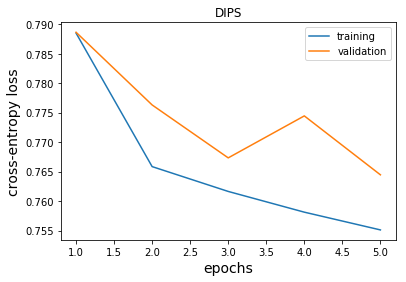

In [15]:
epochs = np.arange(1,len(dips_hist.history['loss'])+1)

plt.plot(epochs,dips_hist.history['loss'],label='training')
plt.plot(epochs,dips_hist.history['val_loss'],label='validation')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('cross-entropy loss',fontsize=14)
plt.legend()
plt.title('DIPS')

plt.show()

Since we're training w/ only 200k jets, we're overfitting right now, which is why the validation loss is not improving even though the training loss is.

**Step 4:** Evaluate the results with a roc curve

In [16]:
# To draw the roc curves faster, look at a subset of the test dataset. 
nTest = 50000

MC16d_ttbar-test-validation_sample-NN.h5
50000/50000 [==============================] - 3s 59us/step
MC16d_Zprime-test-validation_sample-NN.h5
50000/50000 [==============================] - 3s 53us/step


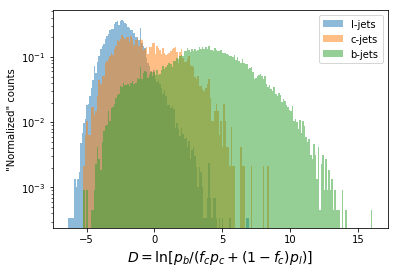

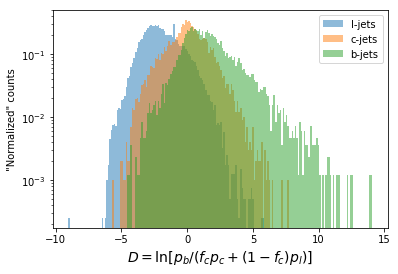

In [17]:
dips_leffs, dips_ceffs, dips_beffs, dips_discs = [], [], [], []

for testfile_name in ["MC16d_ttbar-test-validation_sample-NN.h5","MC16d_Zprime-test-validation_sample-NN.h5"]:
    
    print(testfile_name)
    h5f_test = h5py.File(os.path.join(file_path,testfile_name), 'r')

    X_test = h5f_test['X_trk_test'][:nTest]
    y_test = h5f_test['Y_test'][:nTest]
    
    h5f_test.close()

    (leff, ceff, beff), d = sigBkgEff(dips, X_test[:nTest], y_test[:nTest], returnDisc=True)
     
    dips_leffs.append(leff)
    dips_ceffs.append(ceff)
    dips_beffs.append(beff)
    dips_discs.append(d)
        

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


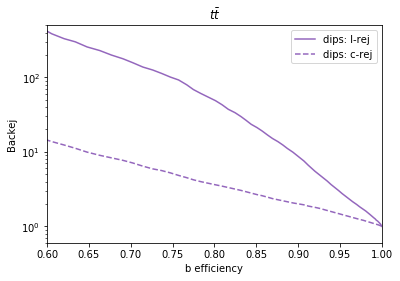

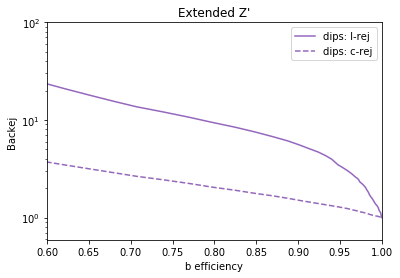

In [18]:
for leff, ceff, beff, title, ymax in zip(dips_leffs, dips_ceffs, dips_beffs, [r'$t\bar{t}$','Extended Z\''],[500,100]):

    # l-rej
    plt.figure()
    plt.plot(beff, 1 / leff, color='C4', label='dips: l-rej')

    # c-rej
    plt.plot(beff, 1 / ceff, color='C4', linestyle='--', label='dips: c-rej')
    plt.xlabel('b efficiency')
    plt.ylabel('Backej')
    
    plt.legend()
    plt.title(title)
    plt.yscale("log")
    plt.xlim(0.6,1)
    plt.ylim(0,ymax)

plt.show()

## First hyperparameters to tune

- number of layers
- size of the layers

- batch normalization
- dropout

*And many more...*

[Tips and tricks for hyperparameter optimization](http://cs231n.github.io/neural-networks-3/)


## Train RNNIP

<img src="img/RNNIP_img.png" width="600">

[ATL-PHYS-PUB-2017-003](https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PUBNOTES/ATL-PHYS-PUB-2017-003/)

[RNN-Overview](http://cs231n.stanford.edu/slides/2019/cs231n_2019_lecture10.pdf)


**Note:** The PFlow extended training has 400 hidden units.

In [19]:
nHidden = 100
nDense = 20

In [20]:
trk_inputs = Input(shape=(nTrks,nFeatures),name="Trk_inputs")
masked_input = Masking()(trk_inputs)

# Feed this merged layer to an RNN
lstm = LSTM(nHidden, return_sequences=False, name='LSTM')(masked_input)
dpt = Dropout(rate=0.2)(lstm)

my_inputs = trk_inputs

# Fully connected layer
FC = Dense(nDense, activation='relu', name="Dense")(dpt)

# Softmax for classification
output = Dense(nClasses, activation='softmax', name="Jet_class")(FC)
rnnip = Model(inputs=my_inputs, outputs=output)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


After defining a different architecture, the rest of the training steps are exactly the same.

In [21]:
rnnip.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['acc'])

In [22]:
rnnip_mChkPt = ModelCheckpoint('rnnip_weights.h5',monitor='val_loss', verbose=True,
                               save_best_only=True,
                               save_weights_only=True)

In [23]:
nEpochs = 2

rnnip_hist = rnnip.fit(X_train,y_train, epochs=nEpochs, batch_size=256,validation_split=0.2,
                 callbacks=[earlyStop, rnnip_mChkPt],)

Train on 160000 samples, validate on 40000 samples
Epoch 1/2
160000/160000 [==============================] - 45s 284us/step - loss: 0.8445 - acc: 0.5849 - val_loss: 0.8185 - val_acc: 0.6005

Epoch 00001: val_loss improved from inf to 0.81849, saving model to rnnip_weights.h5
Epoch 2/2
160000/160000 [==============================] - 44s 276us/step - loss: 0.8057 - acc: 0.6087 - val_loss: 0.7975 - val_acc: 0.6133

Epoch 00002: val_loss improved from 0.81849 to 0.79748, saving model to rnnip_weights.h5


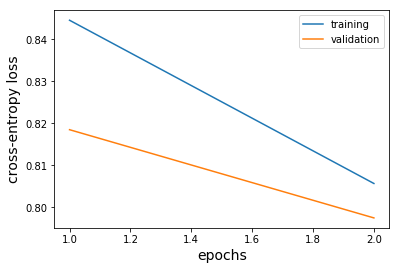

In [24]:
epochs = np.arange(1,len(rnnip_hist.history['loss'])+1)

plt.plot(epochs,rnnip_hist.history['loss'],label='training')
plt.plot(epochs,rnnip_hist.history['val_loss'],label='validation')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('cross-entropy loss',fontsize=14)
plt.legend()

In [25]:
rnn_leffs, rnn_ceffs, rnn_beffs, rnn_discs = [], [], [], []

for testfile_name in ["MC16d_ttbar-test-validation_sample-NN.h5","MC16d_Zprime-test-validation_sample-NN.h5"]:
    
    h5f_test = h5py.File(os.path.join(file_path,testfile_name), 'r')

    X_test = h5f_test['X_trk_test'][:nTest]
    y_test = h5f_test['Y_test'][:nTest]
    
    h5f_test.close()

    (leff, ceff, beff), d = sigBkgEff(rnnip, X_test[:nTest], y_test[:nTest], returnDisc=True)
     
    rnn_leffs.append(leff)
    rnn_ceffs.append(ceff)
    rnn_beffs.append(beff)
    rnn_discs.append(d)
        

NameError: name 'ntest' is not defined

In [ ]:
for leff, ceff, beff, title, ymax in zip(rnn_leffs, rnn_ceffs, rnn_beffs, [r'$t\bar{t}$','Extended Z\''],[500,100]):

    # l-rej
    plt.figure()
    plt.plot(beff, 1 / leff, color='C2', label='rnnip: l-rej')

    # c-rej
    plt.plot(beff, 1 / ceff, color='C2', linestyle='--', label='rnnip: c-rej')
    plt.xlabel('b efficiency')
    plt.ylabel('background rejection')
    
    plt.legend()
    plt.title(title)
    plt.yscale("log")
    plt.xlim(0.6,1)
    plt.ylim(0,ymax)

plt.show()

And that's the workflow! As you might have noticed, there are quite a bit gap between the roc curves here vs the ones in presentations due to small stats and limited time in the tutorial, but feel free to poke around and optimize!!

You can keep track of your results and optimize the roc curves :)


**Other useful resources**

[Energy Flow](https://energyflow.network): A package that comes along w/ the q/g energy flow package which is a wrapped around Keras for Deep-Sets.